# Desenvolvimento de mapa de risco

##### Seja uma cidade com fluxo de pessoas a diferentes capitais com crescimento de casos de um novo agente infecsioso, questiona-se: qual das capitais tem mais chances de exportar o primeiro caso a cidade em questão? 
##### O software a seguir responde a pergunta para quaisquer duas capitais, fazendo uso de uma estimativa dos crescimentos aproximadamente exponenciais dos casos de infecções em cada capital e do movimento pendular de pessoas das capitais para a cidade de interesse.

In [1]:
import pandas as pd # lida com tabelas
import numpy as np # biblioteca numérica
import matplotlib.pyplot as plt # para criação de gráficos
import folium # para criação de mapas
from folium.plugins import HeatMap # para criação de mapa de calor
from branca.colormap import LinearColormap

In [2]:
# tabela contém informações de fluxo de pessoas entre cidades e capitais do Brasil
# contém também parâmetros de crescimento exponencial dos casos de covid em cada capital brasileira
dados = pd.read_csv("tabela com os dados completos para trabalhar.csv",index_col=0)
dados.loc["dia um"] = pd.to_datetime(dados.loc["dia um"],errors='coerce') # conversão para data
parametros = pd.read_csv("parametros.csv")

##### A função a seguir gera uma distribuição de probabilidade que responde a questão: em quantos dias uma cidade terá seu primeiro infectado ao estar com um fluxo de pessoas em movimento pendular a outra cidade em crescimento exponencial de casos?


##### Seja $\mathbf{X}$ a variável aleatória que mapeia o evento da primeira infecção em uma cidade número de dias até sua observação, com parâmetros $a_1, a_2, M>0$ para $a_1<a_2, a_1,a_2\in \mathcal{R}$ e $M \in \mathcal{N}$, a distribuição de probabilidade de $\mathbf{X}$ é definida por    $$        f(x;a_1,a_2,M) = (1-p_x)\prod_{k=1}^{x-1}p_k,    $$    em que $p_k = (1-e^{a_1k-a_2})^M$, para $\frac{a_2}{a_1}>k>0$ e $p_k=0$ para $k\geq\left\lceil \frac{a_2}{a_1} \right\rceil$.

In [3]:
# a -> parâmetros de crecimento exponencial
# M -> fluxo de pessoas em movimento pendular 
# entradas: a e M, probabilidade de selecionar um não infectado = (1-exp(a[1]*t+a[0]))
def distr(a,M): 
    ultimo = -a[0]/a[1] # a cidade será infectada até esse dia
    t = np.arange(0,ultimo) # memoria para dias
    p_t = (1-np.exp(a[1]*t+a[0]))**M # probabilidade de selecionar M's não infectados
    np.append(p_t,1)
    p_dia = np.zeros(p_t.shape) # probabilidade da primeira infecção ocorrer nos dias 1,2,3,4...
    # determina f(x,a1,a2,M) como mostrado na definição anterior 
    aux=1 
    for k in range(0,p_t.size):
        p_dia[k]=aux*(1-p_t[k])
        aux = aux*p_t[k]
    return p_dia


##### Supondo que o movimento pendular de pessoas da capital c1 a cidade c é independente do fluxo de pessoas da capital c2 a cidade c, então, pode-se intuir que a capital c1 oferece mais risco que c2 de infectar a cidade c se $P(X_1<X_2)>P(X_2<X_1)$, em que $P$ indica probabilidade, $X_1$ e $X_2$ são as variáveis aleatórias correspondentes a c1 e c2, respectivamente. Podemos reescrever $P(X_1<X_2)$ como $P(X_2+(-X_1)>0)$. A função a seguir calcula $P(X_2+(-X_1)>0)$ e $P(X_2+(-X_1)<0)$, além de devolver a distribuição de $P(X_2+(-X_1))$ (pode ser útil).


In [4]:
def distx1_x2(x1,x2,atraso):
    if atraso>0:
        x2 = np.pad(x2,(atraso,0),mode='constant',constant_values=(0,0)) # adição de zeros do início da infecção nas capitais
    elif atraso<0:
        x1 = np.pad(x1,(-atraso,0),mode='constant',constant_values=(0,0)) # adição de zeros do início da infecção nas capitais
    x1l=x1.size # tamanho da distribuição de X1
    x2l=x2.size # tamanho da distribuição de X2
    x1m=np.pad(x1,(x2l-1,x2l-1),mode='constant',constant_values=(0,0)) # adição de zeros para facilitar a convolução
    x1ml=x1m.size # tamanho do novo vetor
    p = np.zeros(x1l+x2l) # alocação de memória para as probabilidades de P(X2+(-X1))
    x = np.arange(0,x1l+x2l)-x1l+1 # X2+(-X1)
    px1=0 # P(X2+(-X1)>0)
    px2=0 # P(X2+(-X1)<0)
    # realiza convolução
    for k in range(0,x2l+x1l-1):
        p[k]=(x2*x1m[x1ml-x2l-k:x1ml-k]).sum()
        if x[k]>0:
            px1+=p[k]
        elif x[k]<0:
            px2+=p[k]
    return x,p,px1,px2    


##### Vejamos um exemplo prático, seja a cidade Serra do Salitre em conexão com Belo Horizonte e São Paulo, vejamos qual capital tem maior chance de infectar Serra do Salitre primeiro.

##### Primeiro vejamos como encontrar os dados que precisamos nas bases disponíveis

##### Nas colunas da tabela dados estão as informações das cidades brasileiras indexadas pelo código do IBGE como: nome, latitude, longitude e fluxo de pessoas em movimento pendular das 27 capitais brasileiras

In [12]:
parametros.head()

Unnamed: 0   1100205   1302603   1200401   5002704   1600303   5300108  \
0         a1 -6.854765 -5.128910 -5.812177 -9.042093 -5.565857 -7.774623   
1         a2  0.054700  0.031176  0.041781  0.047915  0.041072  0.058902   

    1400100   5103403   1721000  ...   2704302   4314902   4106902   3106200  \
0 -6.339121 -8.827303 -7.896940  ... -6.580975 -7.451890 -7.965763 -7.602185   
1  0.048552  0.059231  0.050815  ...  0.047488  0.030318  0.036830  0.035902   

    2304400   2611606   2507507   2800308   2408102   3205309  
0 -4.655715 -4.611647 -7.020309 -6.885629 -7.209370 -6.065016  
1  0.026454  0.025746  0.052531  0.054122  0.049743  0.044374  

[2 rows x 28 columns]

##### Em "parametros" as colunas contém as constantes para crescimento exponencial inicial dos casos de covid para cada capital brasileira segundo a expressão $ e^{a_1 k -a_2} $, em que k está em dias.

##### Use a função abaixo para encontrar o código da cidade informando o nome. O código do IBGE tem os dois primeiros dígitos relativos ao estado.

In [5]:
def nome_codigo(s):
    s = s.upper()
    aux = True
    for cidade in dados.columns:
        if s == dados[cidade]["nome"]:
            if aux:
                print("Cidade(s) encontrada(s): ", end="")
            print('"'+cidade+'"   ', end="")
            aux = False
    if aux:
        print("Cidades com esse nome não foram encontradas")
    else:
        print("")

In [6]:
nome_codigo("Serra do Salitre")
nome_codigo("Belo Horizonte")
nome_codigo("São Paulo")

Cidade(s) encontrada(s): "3166808"   
Cidade(s) encontrada(s): "3106200"   
Cidade(s) encontrada(s): "3550308"   


##### A seguir, mostram-se como se distribuem as chances da primeira infecção em Serra do Salitre ocorrer em determinado dia, num devido ao contato com Belo Horizonte e noutro devido ao contato com São Paulo.

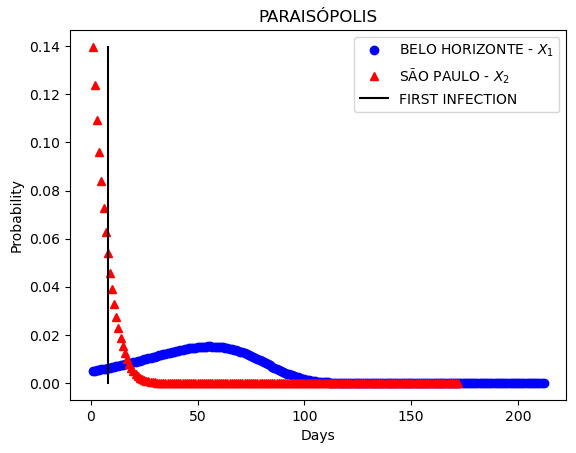

In [11]:
#cidade = "3166808" # códigodo ibge serra do salitre
#cidade = "3125101" # Extrema
cidade = "3147303" # paraisópolis
capital1 = "3106200" # Belo Horizonte
capital2 = "3550308" # São Paulo
dia_apos = [(dados.loc["dia um"][cidade]-dados.loc["dia um"][capital1]).days]
M1 = int(dados[cidade][capital1]) # fluxo de pessoas
par1  = parametros[capital1] # parametros de crecimento dos casos de covid
# plt.plot((dados.loc["dia um"][cidade]-dados.loc["dia um"][capital1]).days,0,'*')
if M1:
    X1 = distr(par1,M1)
    plt.plot(np.arange(1,X1.size+1),X1, "ob", label=dados[capital1]["nome"]+" - $X_1$")
else:
    print("Não há conexão entre a cidade "+dados[cidade]["nome"]+"e " + dados[capital1]["nome"] + "informada pelo IBGE")
M2 = int(dados[cidade][capital2]) # fluxo de pessoas
par2  = parametros[capital2] # parametros de crecimento dos casos de covid
if M2:
    X2 = distr(par2,M2)
    plt.plot(np.arange(1,X2.size+1),X2, "^r", label=dados[capital2]["nome"]+" - $X_2$")
else:
    print("Não há conexão entre a cidade "+dados[cidade]["nome"]+"e " + dados[capital2]["nome"] + "informada pelo IBGE")
plt.plot([dia_apos,dia_apos],[0, np.max([np.max(X1),np.max(X2)])],'k', label="FIRST INFECTION")
plt.legend()
plt.title(dados[cidade]["nome"])
plt.xlabel("Days")
plt.ylabel("Probability")
plt.savefig("Paraisópolis.png")
plt.show()

##### Essas são as duas distribuições para a cidade em questão, nelas é possível notar que o contato com São Paulo acarretará uma infecção com maior verossimilhança antes do dia 50, e Belo Horizonte antes do dia 100. Por isso, pode-se inferir que São Paulo tem mais chances de infectar Serra do Salitre primeiro, vejamos em termos de $P(X_2+(-X_1)>0)$ e $P(X_2+(-X_1)<0)$

Considerando que SÃO PAULO começou o espalhamento 0 dias antes que BELO HORIZONTE
BELO HORIZONTE tem 0.029745071355899596 de probabilidade de infectar PARAISÓPOLIS primeiro que SÃO PAULO
SÃO PAULO tem 0.9643750325500272 de probabilidade de infectar PARAISÓPOLIS primeiro que BELO HORIZONTE
Há 0.005879896094073245 de probabilidade de infectarem com mesmo atraso


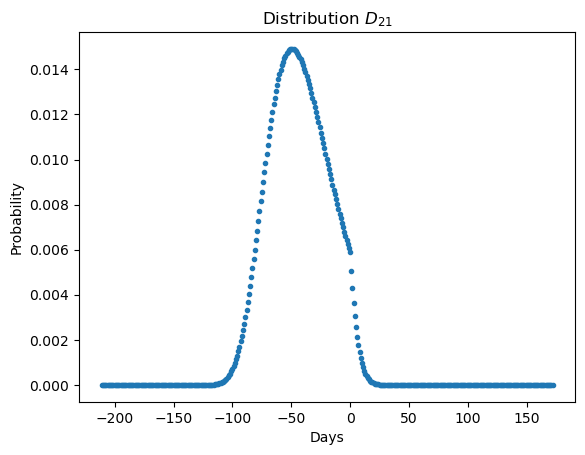

In [12]:
if (M1>0)&(M2>0):
    atraso = 0 # atraso entre a o início das infecções da capital 2 em relação a capital 1, 0 indica que começaram juntas
    conjunta, distribuicao, chance_esquerda, chance_direita = distx1_x2(X1,X2,atraso)
    if atraso>0:
        print("Considerando que " + dados[capital1]["nome"] + " começou o espalhamento " + str(atraso)+" dias antes que " + dados[capital2]["nome"])
    else:
        print("Considerando que " + dados[capital2]["nome"] + " começou o espalhamento " + str(atraso)+" dias antes que " + dados[capital1]["nome"])
    print(dados[capital1]["nome"]+ " tem " + str(chance_esquerda) + " de probabilidade de infectar " + dados[cidade]["nome"]+ " primeiro que " + dados[capital2]["nome"])
    print(dados[capital2]["nome"]+ " tem " + str(chance_direita) + " de probabilidade de infectar " + dados[cidade]["nome"]+ " primeiro que " + dados[capital1]["nome"])
    print("Há " + str(1-chance_esquerda-chance_direita)+ " de probabilidade de infectarem com mesmo atraso")
    plt.plot(conjunta,distribuicao,'.')
    plt.xlabel("Days")
    plt.ylabel("Probability")
    plt.title("Distribution $D_{21}$")
    plt.savefig("Paraisópolis d.png")

# Gerando Mapas

##### Um mapa de risco pode-se ser montado ao considerar a verossimilhança de até determinado dia ocorrer a primieira infecção. Isso seria útil para um gestor mapear as áreas que requerem maior atenção no seu estado.

In [11]:
#capital1 = "3106200" # Belo Horizonte
#capital1 = "4106902" # Curitiba
#capital1 = "3304557" # Rio de Janeiro
#capital1 = "5002704" # Campo Grande
#capital1 = "5208707" # Goiana
#capital1 = "3205309" # Vitória
#capital1 = "2927408" # Salvador
#capital1 = "4205407" # Florianópolis
#capital1 = "4314902" # Porto Alegre
#capital1 = "2408102" # Natal
#capital1 = "2304400" # Fortaleza
#capital1 = "2611606" # Recife
capital1 = "3550308" # São Paulo
mapa_risco = folium.Map(location=[float(dados[capital1]["lat"]), float(dados[capital1]["log"])], zoom_start=7) # geração do mapa

ate = distr(parametros[capital1],10).size
prob_local = [[] for _ in range(ate)]

for cidade in dados.columns: # varre todas as cidades do brasil
    if (cidade[0:2]==capital1[0:2]): # só verifica as do estado de correspondente a capital 1
        if (dados[cidade][capital1]=='0'): # se não houver conexão
            continue
        X1 = distr(parametros[capital1],int(dados[cidade][capital1])) # encontra distribuição
        for ate_dia in range(0,ate): # adiciona probabilidades da infecção ocorrer até dia X a cada frame
            prob_local[ate_dia].extend([[float(dados[cidade]["lat"]), float(dados[cidade]["log"]),X1[0:ate_dia].sum()]])
folium.plugins.HeatMapWithTime(prob_local,radius=25).add_to(mapa_risco) # adiciona frames ao mapa
colormap = LinearColormap(['blue', 'green', 'yellow', 'red'], vmin=0, vmax=1)
colormap.add_to(mapa_risco)
mapa_risco

In [12]:
mapa_risco.save("belo horizonte.html")

##### Um gestor estadual pode querer ter uma visão geral de quais são as capitais que apresentam maior risco de infectar as cidades do estado a fim de considerar interversões adequadas. Do que adiantaria, a exemplo, restringir o fluxo de pessoas da capital do seu estado para cidades interioranas, se parte considerável delas tem maior risco de ser infectada por outra capital. Desse modo, façamos um mapa interativo que mostra essa dinâmica. Como exemplo, vejamos a o risco que São Saulo oferece as cidade de Minas Gerais em comparação a Belo Horizonte.

In [13]:
capital1 = "3106200" # Belo Horizonte
#capital1 = "4106902" # Curitiba
#capital1 = "3304557" # Rio de Janeiro
#capital1 = "5002704" # Campo Grande
#capital1 = "5208707" # Goiana
#capital1 = "3205309" # Vitória
#capital1 = "2927408" # Salvador
#capital1 = "4205407" # Florianópolis
#capital1 = "4314902" # Porto Alegre
#capital1 = "2408102" # Natal
#capital1 = "2304400" # Fortaleza
#capital1 = "2611606" # Recife
capital2 = "3550308" # São Paulo
atraso= (dados[capital2]["dia um"]-dados[capital1]["dia um"]).days
mapa = folium.Map(location=[-21.550520, -46.633308], zoom_start=4) # geração do mapa
#if ((dados[m]["dia um"]-dados[SP]["dia um"]).days>1):

for cidade in dados.columns: # varre todas as cidades do brasil
    if (cidade[0:2]==capital1[0:2]): # só verifica as do estado de correspondente a capital 1
        if (dados[cidade][capital1]=='0')|(dados[cidade][capital2]=='0'): # considera-se apenas as cidades que tenham conexão
            #contsp+=1
            continue
        X1 = distr(parametros[capital1],int(dados[cidade][capital1]))
        X2 = distr(parametros[capital2],int(dados[cidade][capital2]))
        conjunta, distribuicao, chance_x1, chance_x2 = distx1_x2(X1,X2,atraso)
        pop_up = cidade+": " +dados[cidade]["nome"] + "<br> Movimentos pendulares: " +dados[capital1]["nome"] + " " +dados[cidade][capital1]+"<br>" + dados[capital2]["nome"] + " " +dados[cidade][capital2]+ "<br><br>A chance da primeira importação de infectados vir das capitais são: " + dados[capital1]["nome"]+ " - " + str(chance_x1) + " " + dados[capital2]["nome"] + " - " + str(chance_x2)
        if (chance_x1>chance_x2):
            folium.CircleMarker(
            location=[float(dados[cidade]["lat"]), float(dados[cidade]["log"])],
            popup=pop_up,
            radius=5,
            color='blue',
            fill_color='blue',
            fill_opacity=0.7
            #icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(mapa)
        else:
            folium.CircleMarker(
            location=[float(dados[cidade]["lat"]), float(dados[cidade]["log"])],
            popup=pop_up,
            radius=5,
            color='red',
            fill_color='red',
            fill_opacity=0.7
            #icon=folium.Icon(color='red', icon='info-sign')
            ).add_to(mapa)  
folium.CircleMarker(
location=[float(dados[capital1]["lat"]), float(dados[capital1]["log"])],
popup=pop_up,
radius=15,
color='green',
fill_color='green',
fill_opacity=0.7
#icon=folium.Icon(color='red', icon='info-sign')
).add_to(mapa)  

In [14]:
mapa